# Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## Installing needed libraries

In [1]:
# you may need ffmpeg to be installed
!conda install -c conda-forge ffmpeg -y

# please read https://github.com/librosa/librosa
!pip install librosa --user

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.8 MB/s eta 0:00:00a 0:00:01
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py) ... done
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 KB 3.4 MB/s eta 0:00:00a 0:00:01
  Using cached numba-0.56.4-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.5 MB/s eta 0:00:0000:0100:01
  Using cached llvmlite-0.39.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.6 MB)
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_

## Reading and resampling audio tracks database

In [2]:
# for details refer to:
# https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

# prefix = '../datasets/mp3/'
prefix = '../../../datasets/mp3/'
audios = ['ACDC.mp3', 'iamthemorning.mp3', 'Little Big.mp3']
request_audio = 'request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050

# reading all audios
for path in audios:
    dataset[path] = read_and_resample(prefix + path, sample_rate)

# reading request audio
request_data = read_and_resample(prefix + request_audio, sample_rate)

../../../datasets/mp3/ACDC.mp3 length is 4.88 min
../../../datasets/mp3/iamthemorning.mp3 length is 3.83 min
../../../datasets/mp3/Little Big.mp3 length is 2.68 min
../../../datasets/mp3/request.mp3 length is 0.17 min


## Visualizing example spectrogram

We will use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception rather than amplitude.

Spectrogram shape: (128, 12599)


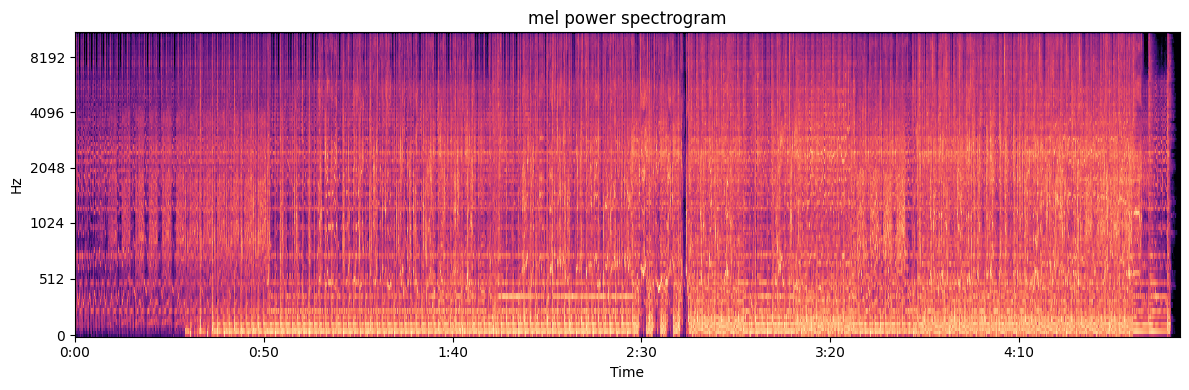

In [3]:
import numpy as np
import matplotlib.pyplot as plt

y = dataset['ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
# plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Forming constellations

We will do something like this from our spectrogram. Not exactly as in the paper, but very similar :)

<img src="https://cdn.dxomark.com/wp-content/uploads/medias/post-50538/Spectrogram_Fingerprinting.png" width="800"/>

This will include:
- get spectrogram
- find local maxima with [computer vision algrithm (wow!)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html): run maximum filtering and then compare original values with filtered.
- `ndimage.label()` labels different connected components
- `ndimage.find_objects()` returns their coordinates
- for each connected component of size 1 (`(dx.stop - dx.start) * (dy.stop - dy.start) == 1`) save a center, which will correspond to a "star"

/tmp/ipykernel_13700/1822892532.py:1: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


Query time resolution 0.0232
File: ACDC.mp3
Points in constellation 6586


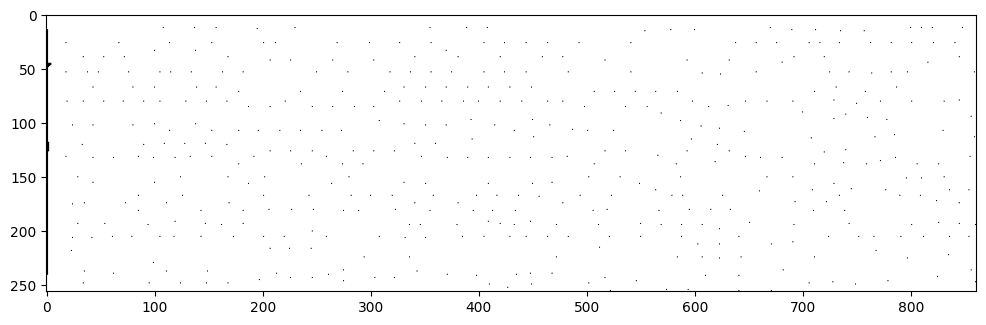

File: iamthemorning.mp3
Points in constellation 5130


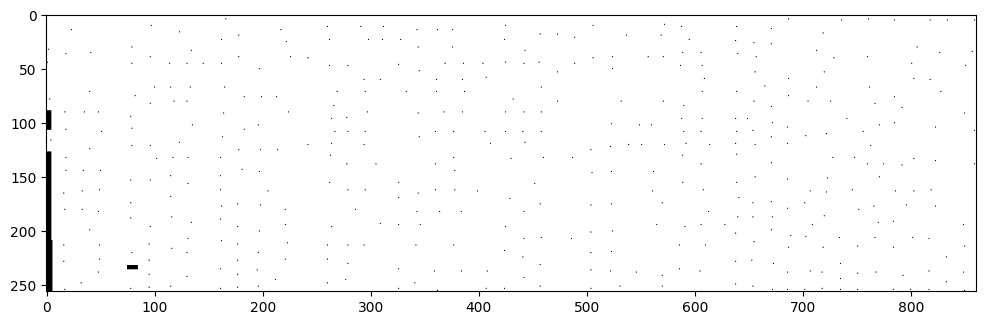

File: Little Big.mp3
Points in constellation 3478


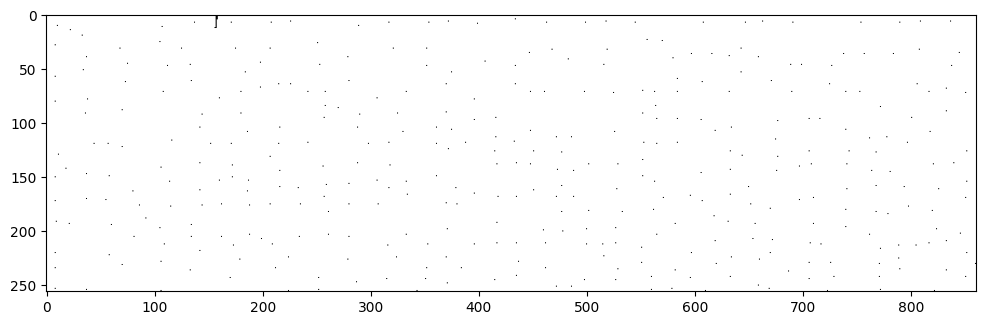

File: request.mp3
Points in constellation 233


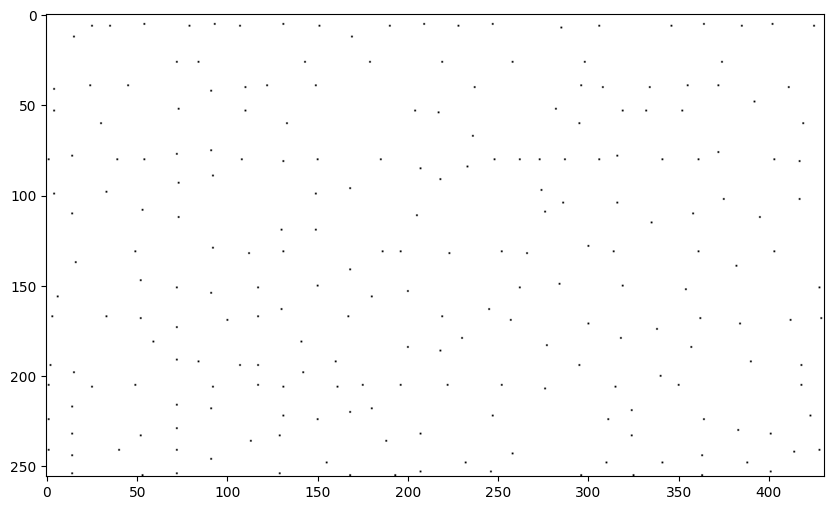

In [4]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print(f"Query time resolution {time_resolution:.4f}")

def form_constellation(name, wav, sample_rate):
    S = librosa.feature.melspectrogram(y=wav, sr=sample_rate, n_mels=256, fmax=4000)
    t_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / t_resolution)
    hi = int(20 / t_resolution)
    print(f"File: {name}")
    print(f"Points in constellation {len(points)}")

    # here we show results of max filter, before removing big blocks. 
    # This is not exactly the same which we saved.
    # Only single-point connected components are in `points` array.
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi], cmap='gray_r')
    plt.show()
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate)

request_constellation = form_constellation(request_audio, request_data, sample_rate)

## Build index from constellations 

Here you will build an in-memory index from constellations. Follow the algorithm:
1. For every "star" $(t_1, f_1)$ on constellation consider some constellation window (`target`) of time and frequency shift. In example this is `(+1, +5) sec` and `(-50, +50) Hz`. In original paper they propose to use SOME "stars". If you propose your own selection method - this is also good, as it speeds up computations.
2. If a "star" $(t_2, f_2)$ falls into a `target` window, create or update and index entry. Form a key as $(f1, f2, \Delta t=t_2-t_1)$, and a value is $(t_1, filename)$.

In [5]:
# (start_time, end_time, freq_Hz_low, freq_Hz_high)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)

index = {}
request = {}

def build_constellation_index(constellation_collection, target):
    # TODO: build shazam index for a collection of constellations
    # consider some window (target) for every point P in constellation.
    # For each point W inside this window (see `target` tuple) make an entry in the index,
    # (or update it, if the key exists).
    # Keys are triplets of the form (f1=P.freq, f2=W.freq, dt=W.time-P.time), 
    # Values are lists with tuples (t=P.time, name=Filename)
    result_index = {}
    
    # TODO: your code here
    for name, points in constellation_collection.items():  
        print(name)
        for point in points:
            f1 = point[1]
            tg = [p for p in points if    
                        point[0] + target[0] <= p[0] < point[0] + target[1]
                        and
                        point[1] + target[2] <= p[1] < point[1] + target[3]
                 ]
            for p in tg:
                f2 = p[1]
                dt = p[0] - point[0]
                t = p[0]
                
                if (f1, f2, dt) in result_index:
                    result_index[(f1, f2, dt)].append((t, name))
                else:
                    result_index[(f1, f2, dt)] = [(t, name)]
    return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

ACDC.mp3
iamthemorning.mp3
Little Big.mp3
request.mp3


## Compare `request.mp3` track with the database using index queries.

1. For every audio file from index find all keys that match query keys.
2. for every such match calculate time offset (difference between audio $t_1$ and query $t_1$)
3. Display counts of matches for every time offset (using histogram, for example)

ACDC.mp3


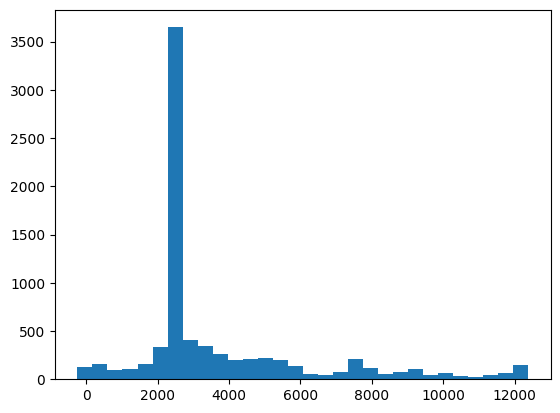

iamthemorning.mp3


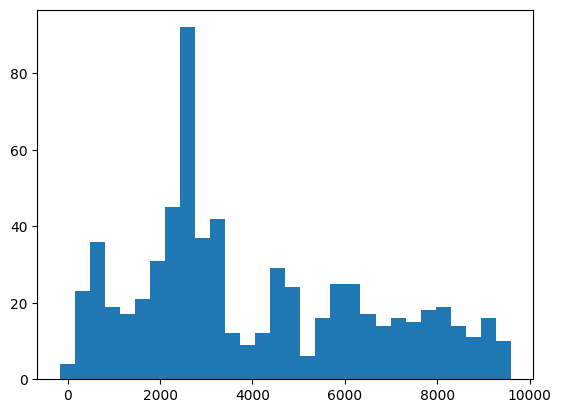

Little Big.mp3


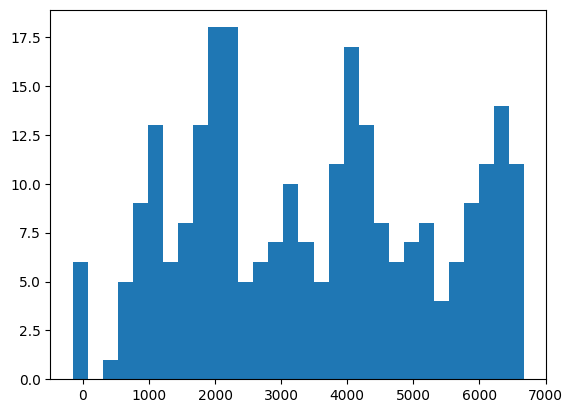

In [6]:
# TODO for every audio find all keys that match request audio keys 
# for every such match calculate time offset (difference between audio and request)
# display counts of matches for every time offset (using histogram, for example)
times = dict((name, []) for name in audios)

for key, v in request.items():
    if key in index:
        for t_r, name_r in v:
            for pair in index[key]:
                t_i, name_i = pair
                times[name_i].append(t_i - t_r)
                
                
for name, data in times.items():
    print(name)
    plt.hist(data, bins=30)
    plt.show()

# 3. Similarity function

Implement a function, which will be estimating similarity of 2 audio tracks in some numbers. It should return 2 numbers: similarity estimation and audio offset (how start of one track is shifted with respect to another, if possible).

We are not giving any particular instructions on HOW to do this, but you can definitely start thinking from:
1. Norming and thresholding.
2. Use [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) to find a peak and some heuristics yo assess its quality. E.g. [in python](https://docs.python.org/3/library/statistics.html).
3. Use [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) statistics to assess the sharpness of distribution. E.g. [in python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html).

../../../datasets/mp3/ACDC.mp3 length is 4.88 min
File: ../../../datasets/mp3/ACDC.mp3
Points in constellation 6586


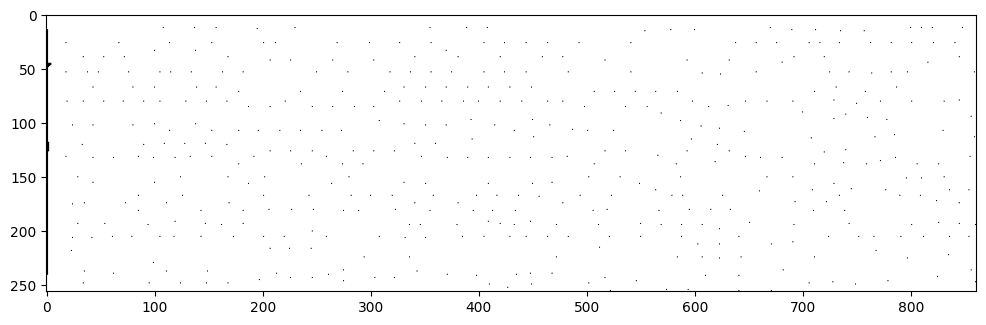

../../../datasets/mp3/ACDC.mp3
../../../datasets/mp3/request.mp3 length is 0.17 min
File: ../../../datasets/mp3/request.mp3
Points in constellation 233


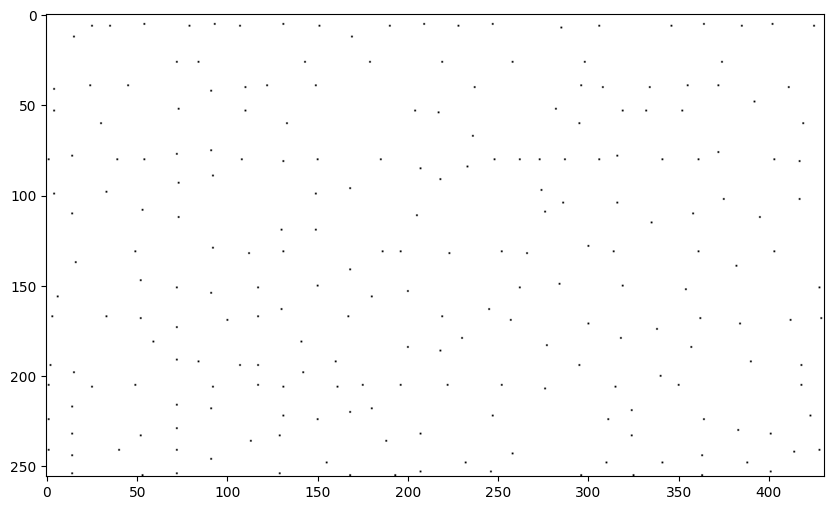

../../../datasets/mp3/request.mp3
Total: 2004
Similarity: 1.6042914171656686
Offset: 59.99976752285168


In [7]:
from collections import Counter
sample_rate = 22050
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)


def similarity(audio, query):

    audio_data = read_and_resample(audio, sample_rate)
    audio_constellation = form_constellation(audio, audio_data, sample_rate)
    audio_idx = build_constellation_index({audio: audio_constellation}, target)
    query_data = read_and_resample(query, sample_rate)
    query_constellation = form_constellation(query, query_data, sample_rate)
    query_idx = build_constellation_index({query: query_constellation}, target)

    times = Counter()
    
    for key, v in query_idx.items():
        qtime = v[0][0]
        if key in audio_idx:
            for match in audio_idx[key]:
                times[match[0] - qtime] += 1

    # print(times.most_common(10))
    mode = times.most_common(1)[0]
    print("Total:", len(times.items()))   # times.total() since 3.10
    print("Similarity:", mode[1] / len(times.items()))
    print("Offset:", mode[0] * time_resolution)
    # ... write your code here
    similarity = mode[1] / len(times.items())
    offset = mode[0] * time_resolution
    return similarity, offset


sim, off = similarity(prefix + 'ACDC.mp3', prefix + 'request.mp3')
assert abs(abs(off) - 60) < 5, "Offset value for these 2 tracks should be around 1 minute."